In [1]:
from IPython.display import clear_output
!pip install h5py
!pip install xarray
!pip install h5netcdf
clear_output()

In [2]:
from IPython.display import clear_output
!pip install --pre astroquery
!conda install -c conda-forge astroquery
# If you do not:
!git clone https://github.com/astropy/astroquery.git
!cd astroquery
!python setup.py install
clear_output()

In [3]:
# Python standard library
import time
import warnings

# Third-party software
import numpy as np

# Astropy
from astropy import coordinates as coord
from astropy import units as u
from astropy.table import Table

# Astroquery. This tutorial requires 0.3.5 or greater.
import astroquery
from astroquery.simbad import Simbad
Simbad.add_votable_fields('flux(V)')
from astroquery.vizier import Vizier
from astroquery.vo_conesearch import conf, conesearch, vos_catalog

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import astropy_mpl_style

from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from google.colab import files
import math
import copy

import pandas as pd
import sys
import cv2
import shutil

import os, shutil
import time
from multiprocessing import Pool
from functools import partial
import xarray as xr

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import albumentations as A

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Remove uncorrect rows

def remove_uncorrect(table):
  #print("Before: " + str(len(table)))
  odd_lines = []
  for row in table:
    num = copy.deepcopy(row.index)
    if ((len(row['RA'].split())!=3) or (len(row['DEC'].split())!=3)):
      odd_lines.append(num)

  table.remove_rows(odd_lines)
  #print("After: " + str(len(table)))

def remove_uncorrect_on_image(table, bound):
  #print("Before: " + str(len(table)))
  odd_lines = []
  for row in table:
    num = copy.deepcopy(row.index)
    if float(row['X'])<=0. or float(row['X'])>=bound or float(row['Y'])<=0. or float(row['Y'])>=bound:
      odd_lines.append(num)
      continue
    if float(row['Gmag'])==0. or np.isnan(float(row['Gmag'])):
        #if float(row['Bmag'])==0. or np.isnan(float(row['Bmag'])):
          odd_lines.append(num)
          continue
    #if float(row['ePos'])>32:
    #  odd_lines.append(num)
    #  continue

  table.remove_rows(odd_lines)
  #print("After: " + str(len(table)))

In [5]:
def join(path_red, path_green, path_blue):
    files_red = glob.glob(path_red+"*.png")
    files_green = glob.glob(path_green+"*.png")
    files_blue = glob.glob(path_blue+"*.png")

    k=0
    for red in files_red:
      green = red.replace('red','green')
      blue = red.replace('red','blue')
      if green in files_green and blue in files_blue:
        im_red = np.asarray(Image.open(red), dtype = np.int16)
        im_green = np.asarray(Image.open(green), dtype = np.int16)
        im_blue = np.asarray(Image.open(blue), dtype = np.int16)
        im =cv2.merge((im_red,im_green,im_blue))
        image = Image.fromarray(im.astype('uint8'), 'RGB')
        image.save(red.replace('red','rgb'))
        coords_file = red.replace('.png','.txt')
        coords_file = coords_file.replace('image','coor')
        shutil.copy(coords_file, coords_file.replace('red','rgb'))
        k+=1
        if k%500==0:
          print(k)

In [40]:
# Convert to PIX

def Wxy(a, b, c, neg):
  if neg:
    return -(((c/60)+b)/60-a);
  return (((c/60)+b)/60+a); 


def ra2Wx(ra):
  RA = [float(i) for i in ra.split()]
  return Wxy(RA[0], RA[1], RA[2], False)*15


def dec2Wy(dec):
  flag = False
  if dec[0] == "-":
    flag = True 
  DEC = [float(i) for i in dec.split()]
  return Wxy(DEC[0], DEC[1], DEC[2], flag)


def separ_a(x):
	return x[0:9]


def separ_b(x):
	return x[9:19]


def add_zeros(x):
  a=x
  if len(a)<19:
     for i in range(19-len(a)):
        a = '0' + a
  return a


def w2p(image, table_stars):
  head = WCS(header=image.header)
  new_table = copy.deepcopy(table_stars)
  k=0
  new_table.add_column(1.0, name='RA') 
  new_table.add_column(1.0, name='DE') 
  for star in table_stars:
      if ~np.isnan(float(star['pmRA'])) and ~np.isnan(float(star['pmDE'])):
          pmRA = (star['pmRA'])
          pmDE = (star['pmDE'])
          world_x = (star['RA_ICRS']-pmRA*6.42/1000./3600.)
          world_y = (star['DE_ICRS']-pmDE*6.42/1000./3600.)
      else:
          world_x = (star['RA_ICRS'])
          world_y = (star['DE_ICRS'])
      x, y = head.all_world2pix(world_x, world_y ,0, tolerance = 1.0e-8, maxiter=40)
      new_table['RA_ICRS'][k] = round(float(x), 8)
      new_table['DE_ICRS'][k] = round(float(y), 8)
      new_table['RA'][k] = round(float(world_x), 8)
      new_table['DE'][k] = round(float(world_y), 8)
      new_table['Gmag'][k] = round(star['Gmag'], 8)
      #new_table['Bmag'][k] = round(star['Bmag'], 8)
      k= k+1
  new_table.rename_column('RA_ICRS', 'X')
  new_table.rename_column('DE_ICRS', 'Y')
  
  
  bound = head.wcs.crpix[0]*2-1.5
  remove_uncorrect_on_image(new_table, bound)
  #new_table.remove_column('Gmag')
  
  new_table.remove_column('pmRA')
  new_table.remove_column('pmDE')
  new_table = new_table.to_pandas()
  # new data frame with split value columns
  
  new_table["Source"] = new_table["Source"].astype('string')
  new_table["Source"] = new_table["Source"].apply(add_zeros)
  new_table["Name_9"] = (new_table["Source"].apply(separ_a)).astype('int64')
  new_table["Name_10"] = (new_table["Source"].apply(separ_b)).astype('int64')

  new_table.pop('Source')
  return new_table


In [7]:
# Find image

def get_image(x, y, rad, pix, cat):
  #Fites = SkyView().get_image_list(position=str(x)+"," + str(y)  ,survey=['DSS'], pixels = 1024, grid = True, projection = 'Tan',  radius=rad*u.deg)
  #print( Fites)
  Fites = SkyView().get_images(position=str(x) + ",  " + str(y) ,survey=[cat], pixels =pix, grid = True, projection = 'Tan',  radius= rad*u.deg)[0][0]
  return Fites

def get_rgb_image(x, y, rad, pix, image_red):
  green = get_image(x, y, rad, pix, 'Mellinger Green')
  blue = get_image(x, y, rad, pix, 'Mellinger Blue')
  im_red = np.asarray(image_red.data, dtype = np.uint8)
  im_green = np.asarray(green.data, dtype = np.uint8)
  im_blue = np.asarray(blue.data, dtype = np.uint8)
  im = cv2.merge((im_red,im_green,im_blue))
  return im


In [48]:
from astroquery.vizier import Vizier
import astropy.units as u
import astropy.coordinates as coord
import pandas as pd
from astropy import table as tb
#I/197A/tic
#I/239/hip_main
def get_table(x,y,rad, m):
  v = Vizier(columns=['RA_ICRS', 'DE_ICRS', 'Gmag', 'pmRA', 'pmDE', 'Source'],#, 'ePos'],
           column_filters={"Gmag":"<" + str(m)})
  v.ROW_LIMIT = 5000000
  result = v.query_region(coord.SkyCoord(ra=x, dec=y,
                                            unit=(u.deg, u.deg),
                                            frame='icrs'),
                        radius=rad*4.*u.deg,
                        catalog=["I/345/gaia2"])
  #print(result[0])

  return result[0]

In [9]:
def get_crop_name(coords):
  a = str(int(coords[5].item()))
  if len(a)<9:
      for i in range(9-len(a)):
        a = '0' + a
  b = str(int(coords[6].item()))
  if len(b)<10:
      for i in range(10-len(b)):
        b = '0' + b
  return a+b
  
def get_crops(image, coords, rad, pix):
  ext_im = []
  ext_co = []
  #except_stars = []
  for star_ind in range(len(coords)):
    #if star_ind not in except_stars:
      name = get_crop_name(coords[star_ind])
      if os.path.exists('dataset'+os.sep+name+".png"):
        continue
      if coords[star_ind][0]>rad and coords[star_ind][0]<pix-rad and coords[star_ind][1]>rad and coords[star_ind][1]<pix-rad:
        x, y, rad = int(coords[star_ind][0]), int(coords[star_ind][1]), int(rad)
        ii = image[:, y-rad:y+rad, x-rad:x+rad]
        cc = torch.tensor([[rad + (coords[star_ind][0]-x), rad + (coords[star_ind][1]-y), coords[star_ind][2],
                            coords[star_ind][3], coords[star_ind][4], coords[star_ind][5], coords[star_ind][6]]])
        #except_stars.append(star_ind)

        xl, xr, yd, yu =x-rad, x+rad, y-rad, y+rad
        for ind in range(len(coords)):
          if ind==star_ind:
            continue
          x, y = coords[ind][0], coords[ind][1]
          if x>xl and x<xr and y>yd and y<yu:
            c2 = torch.tensor([[x-xl, y-yd, coords[ind][2], coords[ind][3], coords[ind][4], coords[ind][5], coords[ind][6]]])
            cc = torch.cat((cc, c2), 0)
          #except_stars.append(ind)
        ext_im.append(ii)
        ext_co.append(cc)

  #return  np.stack(ext_im),  np.stack( ext_co)
  return  ext_im,  ext_co

In [47]:
# Main

def gen_data(x,y, rad, pix, mag, crop_shape):
  table = get_table(x ,y,rad, mag)
  red = get_image(x,y, rad*2., pix, 'Mellinger Red')
  pix_table = w2p(red, table)

  pix_table = np.array(pix_table, dtype = np.float64)
  image = get_rgb_image(x,y, rad*2., pix, red)
  image = np.moveaxis(image, -1, 0)
  crops, coords = get_crops(image, pix_table , int(crop_shape/2), pix)
  #print(crops[0].shape)
  #print(coords[0].shape)
  #show_color_image(crops[0], coords[0])

  return crops, coords



In [11]:
def show_image(data, coor):
  plt.figure(figsize=(10,10))
  img = Image.fromarray(data)
  img = np.array(img)
  img = img/img.max()
  #display(img.resize((256,256), Image.LANCZOS))
  plt.imshow(img, vmin=0, vmax=0.5)    
  coor=np.array(coor)
  plt.scatter(coor[:,0],coor[:,1], c = 'red', s= 4)

def show_color_image(data, coor):
  plt.figure(figsize=(10,10))
  img = (data)
  img = img/img.max()
  #display(img.resize((256,256), Image.LANCZOS))
  plt.imshow(np.transpose(img, (1, 2, 0)), vmin=0, vmax=0.5)    
  coor=np.array(coor)
  plt.scatter(coor[:,0],coor[:,1], c = 'red', s= 1)

In [12]:
import os
from PIL import Image

def get_name(coords):
  a = str(int(coords[0][5].item()))
  if len(a)<9:
      for i in range(9-len(a)):
        a = '0' + a
  b = str(int(coords[0][6].item()))
  if len(b)<10:
      for i in range(10-len(b)):
        b = '0' + b
  return a+b

def dump(folder_name,name,data):
  if not os.path.exists(folder_name):
      os.makedirs(folder_name)
  for i in range(len(data[1])):

    image = np.moveaxis(data[0][i], 0, -1)
    coords = data[1][i]
    name = get_name(coords)
    if os.path.exists('dataset'+os.sep+name+".png"):
     continue
    #image = np.moveaxis(data[0], 0, -1)
    pil = Image.fromarray(image.astype('uint8'), 'RGB') #Image.fromarray(raw_im,'I;16')
    pil.save(os.path.join(folder_name, f"{name}.png"))
    #local_coords = coords.astype(float)
    np.savetxt(os.path.join(folder_name, f"{name}.txt"),coords)

In [57]:
def func3(x, y, Rad, Pix, Mag):
  if True:#not os.path.exists('dataset'+os.sep+name+".png"):
      #clear_output()
      x=1.5*x

      try:
        data = gen_data(x,y, Rad, Pix, Mag, 32)
      except Exception:
        print("Image" ,x,y, "not found")
        return
      dump('dataset',f'{x}_{y}_{step}',data)
      #dataset.append(data)
      print("Image:" ,x,y)
      print("Stars on image:" ,len(data[1]))
      print()

In [54]:

!rm -rf 'dataset'

In [ ]:
# Select star region
# If you have "Error HTTP TimeOut", then shorten the interval
from google.colab import files

y=10
step = 1.5
y = -step
dataset = []
images = []
coords = []
n= 20
m=240

Mag = 9
Rad = 1
Pix = 256
k=0


for i in range(n):
  x = -step
  y += step
  process = 10
  l = len(dataset)
  with Pool(processes=process) as pool:
      pool.map(partial(func3, y=y, Rad=Rad, Pix=Pix, Mag=Mag), range(0, m))

    


Image 9.0 0.0 not found
Image 27.0 0.0 not found
Image 81.0 0.0 not found
Image 18.0 0.0 not found
Image 45.0 0.0 not found
Image 0.0 0.0 not found
Image 54.0 0.0 not found
Image 72.0 0.0 not found
Image: 28.5 0.0
Stars on image: 0

Image: 19.5 0.0
Stars on image: 0

Image: 10.5 0.0
Stars on image: 0
Image: 73.5 0.0

Stars on image: 0
Image: 55.5 0.0

Stars on image: 0

Image: 46.5 0.0
Image: 36.0 0.0
Stars on image: 0
Stars on image: 0


Image: 63.0 0.0
Image: 1.5 0.0
Stars on image: 0
Stars on image: 0


Image: 30.0 0.0
Stars on image: 0

Image: 21.0 0.0
Stars on image: 0

Image: 3.0 0.0
Stars on image: 0

Image: 48.0 0.0
Stars on image: 0

Image: 37.5 0.0
Stars on image: 0

Image: 12.0 0.0
Stars on image: 0

Image: 57.0 0.0
Stars on image: 0

Image: 64.5 0.0
Stars on image: 0

Image: 31.5 0.0
Stars on image: 0

Image: 22.5 0.0
Stars on image: 0

Image: 39.0 0.0
Stars on image: 0

Image: 4.5 0.0
Stars on image: 0

Image: 49.5 0.0
Stars on image: 0

Image: 13.5 0.0
Stars on image: 0



In [ ]:
from google.colab import files
!zip -r dataset.zip dataset
files.download('dataset.zip') 

In [ ]:
from PIL import Image
def show(dataset, l, size, rows, cols, ss):
  plt.style.use(astropy_mpl_style)
  fig = plt.figure(figsize=(size,size))
  number_of_files = len(dataset)
  for i in range(min(number_of_files, l)):
    image_file = dataset[i][0]
    image_data = np.array(image_file.data, dtype = 'int32')
    image_data = image_data/image_data.max()
    a=fig.add_subplot(rows,cols,i+1)
    plt.imshow(image_data,  vmin=0, vmax=0.5, cmap='gray')
    plt.scatter(np.array(dataset[i][1]['X'], dtype = 'float32'),np.array(dataset[i][1]['Y'], dtype = 'float32'), c = 'red', s= ss)
  plt.show()

IndexError: ignored

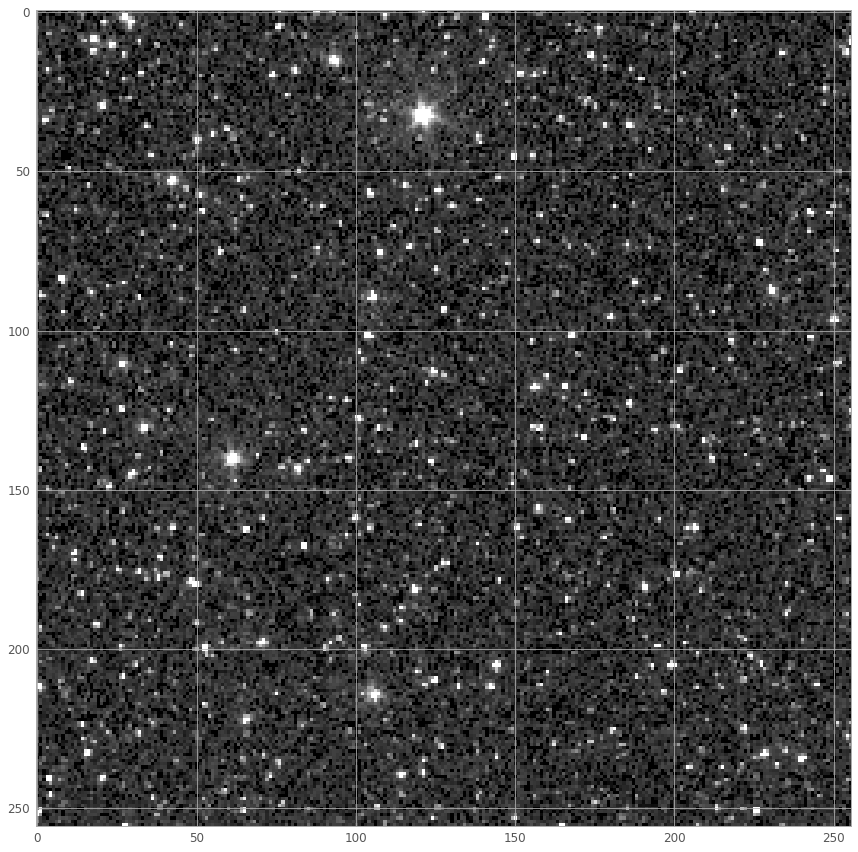

In [ ]:
l = len(dataset)

show(dataset[0], l, 15, 1, 1 , ss=1)